In [124]:
%matplotlib inline
# Dependencies and Setup
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import export_graphviz
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider
import seaborn as sns; sns.set()
import ppscore as pps
import seaborn as seabornInstance 


In [125]:
import warnings
warnings.filterwarnings('ignore')

Read all files as indicated in subsequent cells containing data for labels and NLP formulated features of our project.

In [72]:
L_cap = pd.read_csv("./data/stock_spy.csv")
L_cap = L_cap.loc[L_cap['date']>'2016-01-01']
L_cap = L_cap.loc[:, ["date", "change"]]
L_cap.head(1)

,date,change
4068,2016-01-04,0.002644


In [73]:
M_cap = pd.read_csv("./data/stock_mdy.csv")
M_cap = M_cap.loc[M_cap['date']>'2016-01-01']
M_cap = M_cap.loc[:, ["date", "change"]]
M_cap.head(1)

,date,change
4068,2016-01-04,0.003601


In [74]:
S_cap = pd.read_csv("./data/stock_ijr.csv")
S_cap = S_cap.loc[S_cap['date']>'2016-01-01']
S_cap = S_cap.loc[:, ["date", "change"]]
S_cap.head(1)

,date,change
3924,2016-01-04,-0.006651


In [75]:
trump_econ = pd.read_csv("./data/trump_daydf_count.csv")
trump_econ.sort_values(by=['Date'], inplace=True, ascending=True)
trump_econ.head(1)

,Date,Count
540,2016-01-02,2


In [76]:
trump_favd = pd.read_csv("./data/trump_favd_count.csv")

trump_favd.head(1)

,day,favorites
0,2016-01-01,68955


In [77]:
trump_sentbyday = pd.read_csv("./data/trump_sentbydaydf_count.csv")
trump_sentbyday.sort_values(by=['Date'], inplace=True, ascending=True)
trump_sentbyday.head(1)

,Date,Sent_Count
1813,2016-01-01,2


In [78]:
trump_sentbydaypos = pd.read_csv("./data/trump_sentbydayposdf_count.csv")
trump_sentbydaypos.sort_values(by=['Date'], inplace=True, ascending=True)
trump_sentbydaypos.head(1)

,Date,Pos_Count
1726,2016-01-01,5


In [79]:
trump_sentbydayneg = pd.read_csv("./data/trump_sentbydaynegdf_count.csv")
trump_sentbydayneg.sort_values(by=['Date'], inplace=True, ascending=True)
trump_sentbydayneg.head(1)

,Date,Neg_Count
1638,2016-01-01,3


Merge all the features and label, % change of large-cap daily prices, dataframes together to form the dataframe, trump_mkt, to be used for analyses.  In additiion, a classified label 'pos_neg' is created to determine whether the stock market prices are up (1) or down (0) each day.  

In [80]:
trump_mkt = M_cap.merge(trump_sentbydayneg, how='inner', left_on="date" ,right_on="Date")
trump_mkt = trump_mkt.merge(trump_sentbydaypos, how='inner' ,on="Date")
trump_mkt = trump_mkt.merge(trump_sentbyday, how='inner' ,on="Date")
trump_mkt = trump_mkt.merge(trump_favd, how='inner' , left_on="date" ,right_on="day")
trump_mkt = trump_mkt.merge(trump_econ, how='inner' ,on="Date")
trump_mkt['pos_neg'] = np.where (trump_mkt['change'] > 0,1,0)
trump_mkt['pos'] = np.where (trump_mkt['change'] > 0.002,1,0)
trump_mkt['neg'] = np.where (trump_mkt['change'] < -0.002,1,0)
trump_mkt['flat'] = np.where ((trump_mkt['change'] <= 0.002) & (trump_mkt['change'] >= -0.002) ,1,0)

trump_mkt.head(1)

,date,change,Date,Neg_Count,Pos_Count,Sent_Count,day,favorites,Count,pos_neg,pos,neg,flat
0,2016-01-07,-0.00937,2016-01-07,9,5,-4,2016-01-07,58819,1,0,0,1,0


Add the monthly news releases on employment situations and quarterly real GDP estimates.  Since the data are monthly, the missing daily data are filled with the data on the immediate prior values until the new values are announced. 

In [81]:
trump_empsit = pd.read_csv("./Data/empsit.csv")
trump_empsit.head()
trump_mkt['date'] = pd.to_datetime(trump_mkt['date'])

In [82]:
trump_mkt['job_change']=np.nan
for x in range(len(trump_empsit.index)-1):
   trump_mkt.loc[((trump_mkt['date']>= trump_empsit.loc[x][0]) & (trump_mkt['date']< trump_empsit.loc[x+1][0])),['job_change']]=trump_empsit.loc[x][1]
#    print(wsb_mkt.loc[(wsb_mkt['date']>= wsb_empsit.loc[x][0]) & (wsb_mkt['date']< wsb_empsit.loc[x+1][0])]['job_change'])
trump_mkt.head(1)

,date,change,Date,Neg_Count,Pos_Count,Sent_Count,day,favorites,Count,pos_neg,pos,neg,flat,job_change
0,2016-01-07,-0.00937,2016-01-07,9,5,-4,2016-01-07,58819,1,0,0,1,0,237.0


In [83]:
trump_rgdp = pd.read_csv("./Data/RGDP.csv")
trump_rgdp.head()
trump_mkt['Date'] = pd.to_datetime(trump_mkt['Date'])
#trump_rgdp['Date']=pd.to_datetime(trump_rgdp['Date'])

In [84]:
trump_mkt['growthgap']=np.nan
for x in range(len(trump_rgdp.index)-1):
   trump_mkt.loc[((trump_mkt['date']>= trump_rgdp.loc[x][0]) & (trump_mkt['date']< trump_rgdp.loc[x+1][0])),['growthgap']]=trump_rgdp.loc[x][3]
trump_mkt.head(1)

,date,change,Date,Neg_Count,Pos_Count,Sent_Count,day,favorites,Count,pos_neg,pos,neg,flat,job_change,growthgap
0,2016-01-07,-0.00937,2016-01-07,9,5,-4,2016-01-07,58819,1,0,0,1,0,237.0,-0.5


<Figure size 432x288 with 0 Axes>

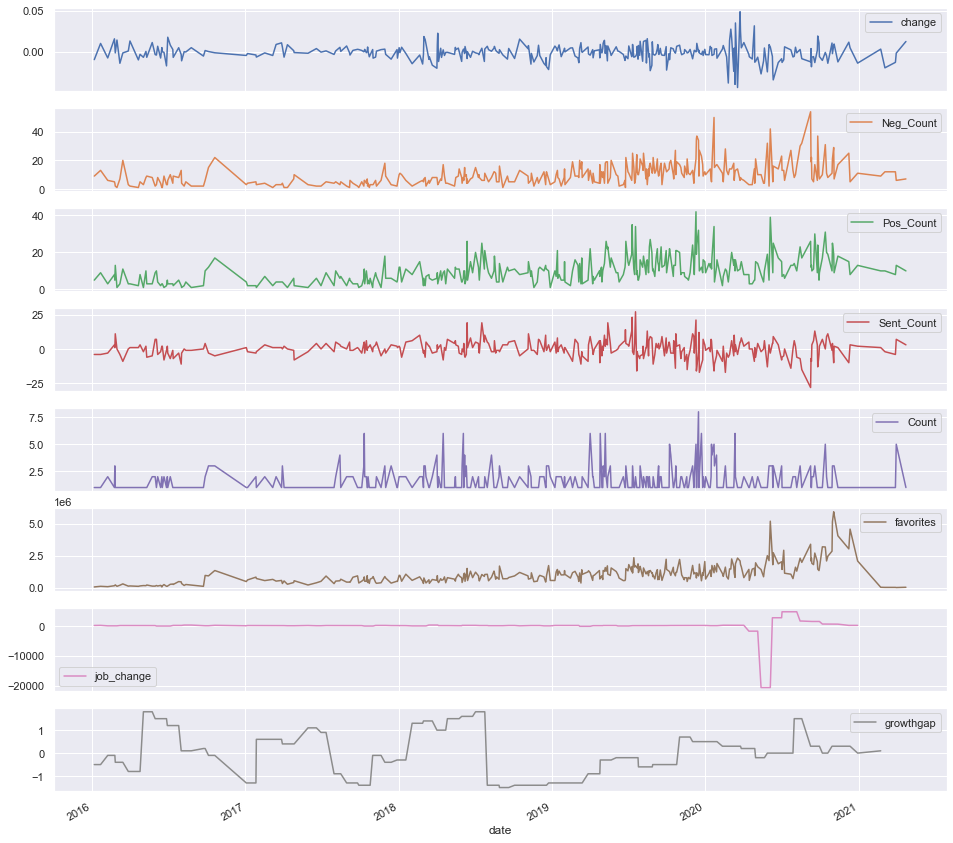

In [85]:
trump_mkt_hm1 = trump_mkt.loc[:, [
    
"date",
"change",
"Neg_Count",
"Pos_Count",
"Sent_Count",
"Count",
"favorites",
"job_change",
"growthgap"

]]
trump_mkt_hm1.set_index('date', inplace=True)
plt.subplots_adjust(bottom=0.25)
trump_mkt_hm1.plot(subplots=True, figsize=(16, 16)); plt.legend(loc='best')

Calculate Predictive Power Score

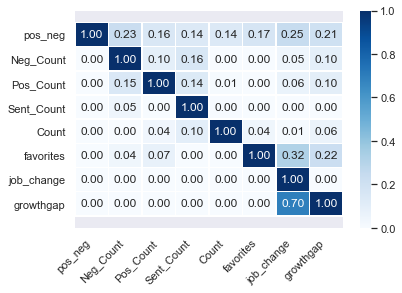

In [126]:
#pps matrix plot
trump_mkt_hm1 = trump_mkt.loc[:, [

"pos_neg",
"Neg_Count",
"Pos_Count",
"Sent_Count",
"Count",
"favorites",
"job_change",
"growthgap"]]

ax = sns.heatmap(pps.matrix(trump_mkt_hm1), vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, fmt=".2f")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
;

# Save Figure
plt.savefig('./Images/trump_MCap_PPS_Matrix.png', figsize=(400,240))

# Show plot
plt.show()

Given the low predictive power above, we may work on improving the predictive power by adding 15 lags of features and the % change of stock prices label to the dataframe based on the rationality that responses to remarks may take more that one day.

In [87]:
trump_mkt['negcount1day'] = trump_mkt['Neg_Count'].shift(1)
trump_mkt['poscount1day'] = trump_mkt['Pos_Count'].shift(1)
trump_mkt['sentcount1day'] = trump_mkt['Sent_Count'].shift(1)
trump_mkt['favcount1day'] = trump_mkt['favorites'].shift(1)
trump_mkt['econcount1day'] = trump_mkt['Count'].shift(1)
trump_mkt['job_change1day'] = trump_mkt['job_change'].shift(1)
trump_mkt['growthgap1day'] = trump_mkt['growthgap'].shift(1)
trump_mkt['change1day'] = trump_mkt['change'].shift(1)
trump_mkt['negcount2day'] = trump_mkt['Neg_Count'].shift(2)
trump_mkt['poscount2day'] = trump_mkt['Pos_Count'].shift(2)
trump_mkt['sentcount2day'] = trump_mkt['Sent_Count'].shift(2)
trump_mkt['favcount2day'] = trump_mkt['favorites'].shift(2)
trump_mkt['econcount2day'] = trump_mkt['Count'].shift(2)
trump_mkt['job_change2day'] = trump_mkt['job_change'].shift(2)
trump_mkt['growthgap2day'] = trump_mkt['growthgap'].shift(2)
trump_mkt['change2day'] = trump_mkt['change'].shift(2)
trump_mkt['negcount3day'] = trump_mkt['Neg_Count'].shift(3)
trump_mkt['poscount3day'] = trump_mkt['Pos_Count'].shift(3)
trump_mkt['sentcount3day'] = trump_mkt['Sent_Count'].shift(3)
trump_mkt['favcount3day'] = trump_mkt['favorites'].shift(3)
trump_mkt['econcount3day'] = trump_mkt['Count'].shift(3)
trump_mkt['job_change3day'] = trump_mkt['job_change'].shift(3)
trump_mkt['growthgap3day'] = trump_mkt['growthgap'].shift(3)
trump_mkt['change3day'] = trump_mkt['change'].shift(3)
trump_mkt['negcount4day'] = trump_mkt['Neg_Count'].shift(4)
trump_mkt['poscount4day'] = trump_mkt['Pos_Count'].shift(4)
trump_mkt['sentcount4day'] = trump_mkt['Sent_Count'].shift(4)
trump_mkt['favcount4day'] = trump_mkt['favorites'].shift(4)
trump_mkt['econcount4day'] = trump_mkt['Count'].shift(4)
trump_mkt['job_change4day'] = trump_mkt['job_change'].shift(4)
trump_mkt['growthgap4day'] = trump_mkt['growthgap'].shift(4)
trump_mkt['change4day'] = trump_mkt['change'].shift(4)
trump_mkt['negcount5day'] = trump_mkt['Neg_Count'].shift(5)
trump_mkt['poscount5day'] = trump_mkt['Pos_Count'].shift(5)
trump_mkt['sentcount5day'] = trump_mkt['Sent_Count'].shift(5)
trump_mkt['favcount5day'] = trump_mkt['favorites'].shift(5)
trump_mkt['econcount5day'] = trump_mkt['Count'].shift(5)
trump_mkt['job_change5day'] = trump_mkt['job_change'].shift(5)
trump_mkt['growthgap5day'] = trump_mkt['growthgap'].shift(5)
trump_mkt['change5day'] = trump_mkt['change'].shift(5)
trump_mkt['negcount6day'] = trump_mkt['Neg_Count'].shift(6)
trump_mkt['poscount6day'] = trump_mkt['Pos_Count'].shift(6)
trump_mkt['sentcount6day'] = trump_mkt['Sent_Count'].shift(6)
trump_mkt['favcount6day'] = trump_mkt['favorites'].shift(6)
trump_mkt['econcount6day'] = trump_mkt['Count'].shift(6)
trump_mkt['job_change6day'] = trump_mkt['job_change'].shift(6)
trump_mkt['growthgap6day'] = trump_mkt['growthgap'].shift(6)
trump_mkt['change6day'] = trump_mkt['change'].shift(6)
trump_mkt['negcount7day'] = trump_mkt['Neg_Count'].shift(7)
trump_mkt['poscount7day'] = trump_mkt['Pos_Count'].shift(7)
trump_mkt['sentcount7day'] = trump_mkt['Sent_Count'].shift(7)
trump_mkt['favcount7day'] = trump_mkt['favorites'].shift(7)
trump_mkt['econcount7day'] = trump_mkt['Count'].shift(7)
trump_mkt['job_change7day'] = trump_mkt['job_change'].shift(7)
trump_mkt['growthgap7day'] = trump_mkt['growthgap'].shift(7)
trump_mkt['change7day'] = trump_mkt['change'].shift(7)
trump_mkt['negcount8day'] = trump_mkt['Neg_Count'].shift(8)
trump_mkt['poscount8day'] = trump_mkt['Pos_Count'].shift(8)
trump_mkt['sentcount8day'] = trump_mkt['Sent_Count'].shift(8)
trump_mkt['favcount8day'] = trump_mkt['favorites'].shift(8)
trump_mkt['econcount8day'] = trump_mkt['Count'].shift(8)
trump_mkt['job_change8day'] = trump_mkt['job_change'].shift(8)
trump_mkt['growthgap8day'] = trump_mkt['growthgap'].shift(8)
trump_mkt['change8day'] = trump_mkt['change'].shift(8)
trump_mkt['negcount9day'] = trump_mkt['Neg_Count'].shift(9)
trump_mkt['poscount9day'] = trump_mkt['Pos_Count'].shift(9)
trump_mkt['sentcount9day'] = trump_mkt['Sent_Count'].shift(9)
trump_mkt['favcount9day'] = trump_mkt['favorites'].shift(9)
trump_mkt['econcount9day'] = trump_mkt['Count'].shift(9)
trump_mkt['job_change9day'] = trump_mkt['job_change'].shift(9)
trump_mkt['growthgap9day'] = trump_mkt['growthgap'].shift(9)
trump_mkt['change9day'] = trump_mkt['change'].shift(9)
trump_mkt['negcount10day'] = trump_mkt['Neg_Count'].shift(10)
trump_mkt['poscount10day'] = trump_mkt['Pos_Count'].shift(10)
trump_mkt['sentcount10day'] = trump_mkt['Sent_Count'].shift(10)
trump_mkt['favcount10day'] = trump_mkt['favorites'].shift(10)
trump_mkt['econcount10day'] = trump_mkt['Count'].shift(10)
trump_mkt['job_change10day'] = trump_mkt['job_change'].shift(10)
trump_mkt['growthgap10day'] = trump_mkt['growthgap'].shift(10)
trump_mkt['change10day'] = trump_mkt['change'].shift(10)
trump_mkt['negcount11day'] = trump_mkt['Neg_Count'].shift(11)
trump_mkt['poscount11day'] = trump_mkt['Pos_Count'].shift(11)
trump_mkt['sentcount11day'] = trump_mkt['Sent_Count'].shift(11)
trump_mkt['favcount11day'] = trump_mkt['favorites'].shift(11)
trump_mkt['econcount11day'] = trump_mkt['Count'].shift(11)
trump_mkt['job_change11day'] = trump_mkt['job_change'].shift(11)
trump_mkt['growthgap11day'] = trump_mkt['growthgap'].shift(11)
trump_mkt['change11day'] = trump_mkt['change'].shift(11)
trump_mkt['negcount12day'] = trump_mkt['Neg_Count'].shift(12)
trump_mkt['poscount12day'] = trump_mkt['Pos_Count'].shift(12)
trump_mkt['sentcount12day'] = trump_mkt['Sent_Count'].shift(12)
trump_mkt['favcount12day'] = trump_mkt['favorites'].shift(12)
trump_mkt['econcount12day'] = trump_mkt['Count'].shift(12)
trump_mkt['job_change12day'] = trump_mkt['job_change'].shift(12)
trump_mkt['growthgap12day'] = trump_mkt['growthgap'].shift(12)
trump_mkt['change12day'] = trump_mkt['change'].shift(12)
trump_mkt['negcount13day'] = trump_mkt['Neg_Count'].shift(13)
trump_mkt['poscount13day'] = trump_mkt['Pos_Count'].shift(13)
trump_mkt['sentcount13day'] = trump_mkt['Sent_Count'].shift(13)
trump_mkt['favcount13day'] = trump_mkt['favorites'].shift(13)
trump_mkt['econcount13day'] = trump_mkt['Count'].shift(13)
trump_mkt['job_change13day'] = trump_mkt['job_change'].shift(13)
trump_mkt['growthgap13day'] = trump_mkt['growthgap'].shift(13)
trump_mkt['change13day'] = trump_mkt['change'].shift(13)
trump_mkt['negcount14day'] = trump_mkt['Neg_Count'].shift(14)
trump_mkt['poscount14day'] = trump_mkt['Pos_Count'].shift(14)
trump_mkt['sentcount14day'] = trump_mkt['Sent_Count'].shift(14)
trump_mkt['favcount14day'] = trump_mkt['favorites'].shift(14)
trump_mkt['econcount14day'] = trump_mkt['Count'].shift(14)
trump_mkt['job_change14day'] = trump_mkt['job_change'].shift(14)
trump_mkt['growthgap14day'] = trump_mkt['growthgap'].shift(14)
trump_mkt['change14day'] = trump_mkt['change'].shift(14)
trump_mkt['negcount15day'] = trump_mkt['Neg_Count'].shift(15)
trump_mkt['poscount15day'] = trump_mkt['Pos_Count'].shift(15)
trump_mkt['sentcount15day'] = trump_mkt['Sent_Count'].shift(15)
trump_mkt['favcount15day'] = trump_mkt['favorites'].shift(15)
trump_mkt['econcount15day'] = trump_mkt['Count'].shift(15)
trump_mkt['job_change15day'] = trump_mkt['job_change'].shift(15)
trump_mkt['growthgap15day'] = trump_mkt['growthgap'].shift(15)
trump_mkt['change15day'] = trump_mkt['change'].shift(15)
trump_mkt.head(1)

,date,change,Date,Neg_Count,Pos_Count,Sent_Count,day,favorites,Count,pos_neg,...,growthgap14day,change14day,negcount15day,poscount15day,sentcount15day,favcount15day,econcount15day,job_change15day,growthgap15day,change15day
0,2016-01-07,-0.00937,2016-01-07,9,5,-4,2016-01-07,58819,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
trump_mkt.to_csv('./Data/trump_mmkt.csv', index=False)

In [89]:
for x in trump_mkt.columns:
    print(x)

date
change
Date
Neg_Count
Pos_Count
Sent_Count
day
favorites
Count
pos_neg
pos
neg
flat
job_change
growthgap
negcount1day
poscount1day
sentcount1day
favcount1day
econcount1day
job_change1day
growthgap1day
change1day
negcount2day
poscount2day
sentcount2day
favcount2day
econcount2day
job_change2day
growthgap2day
change2day
negcount3day
poscount3day
sentcount3day
favcount3day
econcount3day
job_change3day
growthgap3day
change3day
negcount4day
poscount4day
sentcount4day
favcount4day
econcount4day
job_change4day
growthgap4day
change4day
negcount5day
poscount5day
sentcount5day
favcount5day
econcount5day
job_change5day
growthgap5day
change5day
negcount6day
poscount6day
sentcount6day
favcount6day
econcount6day
job_change6day
growthgap6day
change6day
negcount7day
poscount7day
sentcount7day
favcount7day
econcount7day
job_change7day
growthgap7day
change7day
negcount8day
poscount8day
sentcount8day
favcount8day
econcount8day
job_change8day
growthgap8day
change8day
negcount9day
poscount9day
sentcoun

Machine Learning Models: RandomForesRegression & Ridge for the model with % change of prices for SPY, MDY and IJR as labels; RandomClassifier and LogisticRegressor for the models with labels as classifiers of price change directions -- up or down. The RandomFlorest models also oberve feature importance and decision trees.

In [30]:
trump_mkt.dropna(inplace=True)
trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #1 %Change (y_3)
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #2 Classification Change (y_1)
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9]] #3 y_1 Neg_Count, Pos_Count, favorites, Count
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9]] #4 Sent_Count, favorites, Count
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:8]] #4.1 Sent_Count, favorites

trump_mmkt_x.set_index("date", inplace=True)
trump_mmkt_y1 = trump_mkt['pos_neg']
#trump_mmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_mmkt_y3 = trump_mkt[['change']]
trump_mmkt_x.head(1)
#trump_mmkt_x.to_csv('./Data/trump_mmkt_x.csv', index=True)
#trump_mmkt_y1.to_csv('./Data/trump_mmkt_y1.csv', index=False)

,Neg_Count,Pos_Count,favorites,Count,job_change,growthgap
date,,,,,,
2016-05-11,9,3,211703,1,197.0,1.8


In [31]:
X_train, X_test,y_train,y_test = train_test_split(trump_mmkt_x, trump_mmkt_y3, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#1 %Change

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

-0.26679076730736173
-0.05860073488648676


In [ ]:
trump_mkt.dropna(inplace=True)
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #1 %Change (y_3)
trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #2 Classification Change (y_1)
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9]] #3 y_1 Neg_Count, Pos_Count, favorites, Count
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9]] #4 Sent_Count, favorites, Count
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:8]] #4.1 Sent_Count, favorites

trump_mmkt_x.set_index("date", inplace=True)
trump_mmkt_y1 = trump_mkt['pos_neg']
#trump_mmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_mmkt_y3 = trump_mkt[['change']]
trump_mmkt_x.head(1)
#trump_mmkt_x.to_csv('./Data/trump_mmkt_x.csv', index=True)
#trump_mmkt_y1.to_csv('./Data/trump_mmkt_y1.csv', index=False)

In [32]:
X_train, X_test,y_train,y_test = train_test_split(trump_mmkt_x, trump_mmkt_y1, test_size = 0.33,random_state=42)

from sklearn.ensemble import RandomForestClassifier

regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#2 Pos_Count, Neg_Count, Count, job_change, growthgap

from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

0.45132743362831856
0.48672566371681414


In [33]:
trump_mkt.dropna(inplace=True)
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #1 %Change (y_3)
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #2 Classification Change (y_1)
trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9]] #3 y_1 Neg_Count, Pos_Count, favorites, Count
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9]] #4 Sent_Count, favorites, Count
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:8]] #4.1 Sent_Count, favorites

trump_mmkt_x.set_index("date", inplace=True)
trump_mmkt_y1 = trump_mkt['pos_neg']
#trump_mmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_mmkt_y3 = trump_mkt[['change']]
trump_mmkt_x.head(1)
#trump_mmkt_x.to_csv('./Data/trump_mmkt_x.csv', index=True)
#trump_mmkt_y1.to_csv('./Data/trump_mmkt_y1.csv', index=False)

,Neg_Count,Pos_Count,favorites,Count
date,,,,
2016-05-11,9,3,211703,1


In [34]:
X_train, X_test,y_train,y_test = train_test_split(trump_mmkt_x, trump_mmkt_y1, test_size = 0.33,random_state=42)

regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#3 Pos_Count, Neg_Count, favorites, Count

ridge = RidgeClassifier()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

0.48672566371681414
0.4690265486725664


In [38]:
trump_mkt.dropna(inplace=True)
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #1 %Change (y_3)
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #2 Classification Change (y_1)
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9]] #3 y_1 Neg_Count, Pos_Count, favorites, Count
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9]] #4 Sent_Count, favorites, Count
trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:8]] #4.1 Sent_Count, favorites

trump_mmkt_x.set_index("date", inplace=True)
trump_mmkt_y1 = trump_mkt['pos_neg']
#trump_mmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_mmkt_y3 = trump_mkt[['change']]
trump_mmkt_x.head(1)
#trump_mmkt_x.to_csv('./Data/trump_mmkt_x.csv', index=True)
#trump_mmkt_y1.to_csv('./Data/trump_mmkt_y1.csv', index=False)

,Sent_Count,favorites
date,,
2016-05-11,-6,211703


In [39]:
X_train, X_test,y_train,y_test = train_test_split(trump_mmkt_x, trump_mmkt_y1, test_size = 0.33,random_state=42)

regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#4.1 Sent_Count, favorites

ridge = RidgeClassifier()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

0.5929203539823009
0.504424778761062


In [37]:
X_train, X_test,y_train,y_test = train_test_split(trump_mmkt_x, trump_mmkt_y1, test_size = 0.33,random_state=42)

regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#4 Sent_Count, favorites, Count

ridge = RidgeClassifier()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

0.5309734513274337
0.49557522123893805


In [44]:
trump_mkt.dropna(inplace=True)

trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9, 17:23]] #5 with 1 lag
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9, 17:23, 25:31, 33:39, 41:47, 49:55, 57:63, 65:71]] #6 with 7 lags
#trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9, 17:23, 25:31, 33:39, 41:47, 49:55, 57:63, 65:71, 73:79, 81:87, 89:95, 97:103, 105:111, 113:119, 121:127, 129:135]] #7 with 15 lags

trump_mmkt_x.set_index("date", inplace=True)
trump_mmkt_y1 = trump_mkt['pos_neg']
trump_mmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_mmkt_y3 = trump_mkt[['change']]
trump_mmkt_x.head(1)
#trump_mmkt_x.to_csv('./Data/trump_mmkt_x.csv', index=True)
#trump_mmkt_y1.to_csv('./Data/trump_mmkt_y1.csv', index=False)

,Sent_Count,favorites,Count,sentcount1day,favcount1day,econcount1day,job_change1day,growthgap1day,change1day
date,,,,,,,,,
2016-05-11,-6,211703,1,2.0,159922.0,1.0,197.0,1.8,0.000568


In [46]:
X_train, X_test,y_train,y_test = train_test_split(trump_mmkt_x, trump_mmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))


#5 with 1 lag final model

ridge = RidgeClassifier()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))

sorted(zip(regr.feature_importances_, trump_mkt.iloc[:, np.r_[5:6, 7:9, 17:23]]), reverse=True)


0.4778761061946903
0.584070796460177


[(0.1888808991233418, 'favorites'),
 (0.14242989823777008, 'sentcount1day'),
 (0.14236618358530373, 'change1day'),
 (0.12817817613916252, 'job_change1day'),
 (0.12678697077309467, 'favcount1day'),
 (0.09745710937575268, 'growthgap1day'),
 (0.08498083147726597, 'Sent_Count'),
 (0.058982870615867905, 'Count'),
 (0.029937060672440768, 'econcount1day')]

In [43]:
X_train, X_test,y_train,y_test = train_test_split(trump_mmkt_x, trump_mmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))


#6 with 7 lags

ridge = RidgeClassifier()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

sorted(zip(regr.feature_importances_, trump_mkt.iloc[:, np.r_[5:6, 7:9, 17:23, 25:31, 33:39, 41:47, 49:55, 57:63, 65:71]]), reverse=True)

0.4778761061946903
0.5309734513274337


[(0.04750633953164548, 'change5day'),
 (0.04580029113134687, 'favcount6day'),
 (0.04432690476493867, 'favcount1day'),
 (0.04403256362496399, 'change7day'),
 (0.04307179240530865, 'change1day'),
 (0.04224743270392497, 'change6day'),
 (0.0383439341813761, 'change3day'),
 (0.03433562355384155, 'favcount3day'),
 (0.03311489572269581, 'sentcount1day'),
 (0.032320315239892504, 'sentcount3day'),
 (0.030126011050061696, 'favcount5day'),
 (0.028135434807037434, 'sentcount7day'),
 (0.028030164786145936, 'change4day'),
 (0.027650139936964982, 'sentcount5day'),
 (0.027649787816709112, 'favcount7day'),
 (0.026785534756581023, 'favcount4day'),
 (0.025355830376400604, 'favcount2day'),
 (0.0248785395573874, 'growthgap5day'),
 (0.022253068091718977, 'econcount4day'),
 (0.021754036065957157, 'job_change1day'),
 (0.02088325136666258, 'job_change7day'),
 (0.020828327873631036, 'Sent_Count'),
 (0.020817465083128327, 'job_change4day'),
 (0.02046999196388176, 'job_change5day'),
 (0.0183380781741434, 'job_cha

In [41]:
X_train, X_test,y_train,y_test = train_test_split(trump_mmkt_x, trump_mmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#7 with 15 lags

ridge = RidgeClassifier()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

sorted(zip(regr.feature_importances_, trump_mkt.iloc[:, np.r_[5:6, 7:9, 17:23, 25:31, 33:39, 41:47, 49:55, 57:63, 65:71, 73:79, 81:87, 89:95, 97:103, 105:111, 113:119, 121:127, 129:135]]), reverse=True)

0.4778761061946903
0.5398230088495575


[(0.03838169553286344, 'change14day'),
 (0.0334679800935377, 'favcount13day'),
 (0.027649774951212496, 'job_change13day'),
 (0.02763378713661003, 'change10day'),
 (0.025868738019860005, 'favcount15day'),
 (0.02523109914271431, 'change11day'),
 (0.02522768351261172, 'favcount11day'),
 (0.02360534748682141, 'sentcount1day'),
 (0.02153079436095974, 'job_change2day'),
 (0.02144295449218616, 'change4day'),
 (0.021322852659303584, 'change3day'),
 (0.02078708402630301, 'change2day'),
 (0.020690059765578687, 'sentcount15day'),
 (0.020412075614568898, 'favorites'),
 (0.019742980350098274, 'change9day'),
 (0.018788378372345624, 'favcount8day'),
 (0.01872508168010032, 'change8day'),
 (0.01851408109672407, 'change15day'),
 (0.017346831379429266, 'change13day'),
 (0.01723757716870323, 'econcount3day'),
 (0.017097628976181844, 'job_change11day'),
 (0.016857255129290215, 'sentcount10day'),
 (0.016207127032993124, 'favcount1day'),
 (0.015880537020853347, 'favcount7day'),
 (0.01531057830253257, 'favcou

In [118]:
trump_mkt.dropna(inplace=True)

trump_mmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:8]] #4.1 Sent_Count, favorites

trump_mmkt_x.set_index("date", inplace=True)
trump_mmkt_y1 = trump_mkt['pos_neg']
#trump_mmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_mmkt_y3 = trump_mkt[['change']]
trump_mmkt_x.head(1)
trump_mmkt_x.to_csv('./Data/trump_mmkt_x.csv', index=True)
trump_mmkt_y1.to_csv('./Data/trump_mmkt_y1.csv', index=False)

In [109]:
X_train, X_test,y_train,y_test = train_test_split(trump_mmkt_x, trump_mmkt_y1, test_size = 0.33,random_state=42)

regrfn = RandomForestClassifier()
regrfn.fit(X_train,y_train)
print(regrfn.score(X_test, y_test))

#4.1 Sent_Count, favorites; final model


regrfn.predict_proba(X_test)


0.584070796460177


array([[0.9, 0.1],
       [0.1, 0.9],
       [0.3, 0.7],
       [0.6, 0.4],
       [0.3, 0.7],
       [0.4, 0.6],
       [1. , 0. ],
       [0.7, 0.3],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.8, 0.2],
       [0.6, 0.4],
       [0.5, 0.5],
       [0.8, 0.2],
       [0.1, 0.9],
       [0.4, 0.6],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.4, 0.6],
       [0.2, 0.8],
       [0.6, 0.4],
       [0. , 1. ],
       [0.7, 0.3],
       [0.9, 0.1],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.8, 0.2],
       [0.6, 0.4],
       [0.7, 0.3],
       [0.3, 0.7],
       [0.7, 0.3],
       [1. , 0. ],
       [0.1, 0.9],
       [0.5, 0.5],
       [0.7, 0.3],
       [0.9, 0.1],
       [0. , 1. ],
       [0.8, 0.2],
       [0.2, 0.8],
       [0.6, 0.4],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0.1, 0.9],
       [0.2, 0.8],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.7,

In [110]:
# Calculate classification report
from sklearn.metrics import classification_report
y_pred = regrfn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65        64
           1       0.52      0.47      0.49        49

    accuracy                           0.58       113
   macro avg       0.57      0.57      0.57       113
weighted avg       0.58      0.58      0.58       113



In [111]:
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
confusion_matrix(y_test, y_pred)

array([[43, 21],
       [26, 23]], dtype=int64)

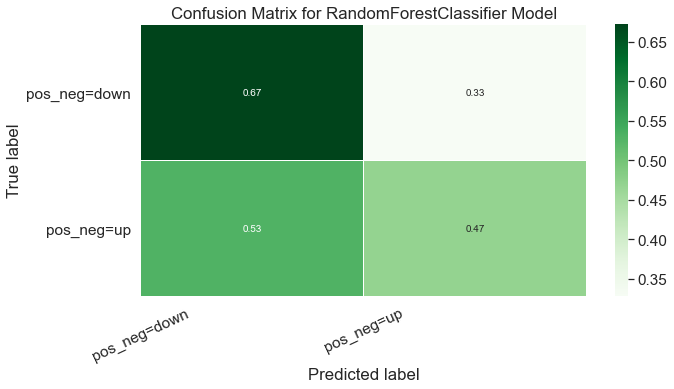

In [119]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
# Add labels to the plot
class_names = ['pos_neg=down', 'pos_neg=up']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for RandomForestClassifier Model')
plt.savefig('./Images/trump_MCap_rf_y_pred_confusion_matrix.png', bbox_inches="tight")
plt.show()

In [120]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.5706313775510204

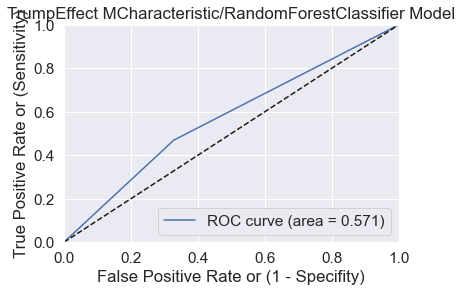

In [121]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('TrumpEffect MCharacteristic/RandomForestClassifier Model')
plt.legend(loc="lower right")
plt.savefig('./Images/trump_MCap_rf_y_pred.png', bbox_inches="tight")

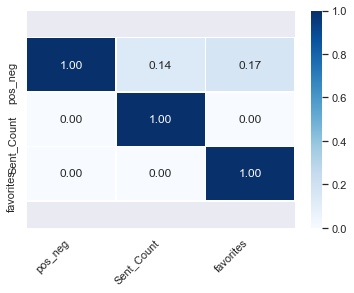

In [128]:
#pps matrix plot
trump_mkt_hm1 = trump_mkt.loc[:, [
    
"pos_neg",
"Sent_Count",
"favorites"
    
]]

ax = sns.heatmap(pps.matrix(trump_mkt_hm1), vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, fmt=".2f")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
;

# Save Figure
plt.savefig('./Images/trump_MCapM_PPS_Matrix.png', bbox_inches="tight")

# Show plot
plt.show()

In [131]:
filename = 'trump_mdcap_model.sav'
pickle.dump(regrfn, open(filename, 'wb'))